In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
from scipy import linalg
import torchvision.models as models

# ------------------------
# HYPERPARAMETERS (UPDATED)
# ------------------------
batch_size = 128
learning_rate = 2e-4
num_epochs = 200
latent_dim = 256
adv_weight = 0.1  # Weight for adversarial loss

# ------------------------
# MODELS
# ------------------------

class VAE_GAN(nn.Module):
    def __init__(self, latent_dim):
        super(VAE_GAN, self).__init__()
        
        # Enhanced Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
        )
        
        self.fc_mu = nn.Linear(256 * 4 * 4, latent_dim)
        self.fc_logvar = nn.Linear(256 * 4 * 4, latent_dim)
        
        # Enhanced Decoder/Generator
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256 * 4 * 4),
            nn.Unflatten(1, (256, 4, 4)),
            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, 4, 2, 1),
            nn.Tanh()
        )

    def decode(self, z):
        """Direct decoding from latent space"""
        return self.decoder(z)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        # Encoding
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        mu, logvar = self.fc_mu(x), self.fc_logvar(x)
        z = self.reparameterize(mu, logvar)
        
        # Decoding
        recon = self.decoder(z)
        return recon, mu, logvar

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 1, 4, 1, 0),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.model(x)
        return x.view(-1)

# ------------------------
# LOSSES & OPTIMIZERS
# ------------------------

def vae_loss(recon_x, x, mu, logvar):
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_loss

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vae = VAE_GAN(latent_dim).to(device)
discriminator = Discriminator().to(device)

optimizer_G = torch.optim.Adam(vae.parameters(), lr=learning_rate, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=learning_rate/2, betas=(0.5, 0.999))

# ------------------------
# TRAINING LOOP
# ------------------------

def train_vae_gan(epochs):
    vae.train()
    discriminator.train()
    
    for epoch in range(epochs):
        total_loss_g = 0
        total_loss_d = 0
        
        for x, _ in train_loader:
            x = x.to(device)
            x = (x - 0.5) * 2.0  # Scale to [-1, 1]
            
            # ---------------------
            # Train Discriminator
            # ---------------------
            optimizer_D.zero_grad()
            
            # Real images
            real_pred = discriminator(x)
            loss_real = F.binary_cross_entropy(real_pred, torch.ones_like(real_pred))
            
            # Fake images
            recon, mu, logvar = vae(x)
            fake_pred = discriminator(recon.detach())
            loss_fake = F.binary_cross_entropy(fake_pred, torch.zeros_like(fake_pred))
            
            d_loss = (loss_real + loss_fake) / 2
            d_loss.backward()
            optimizer_D.step()
            
            # ---------------------
            # Train Generator (VAE)
            # ---------------------
            optimizer_G.zero_grad()
            
            # Reconstruction loss
            loss_vae = vae_loss(recon, x, mu, logvar)
            
            # Adversarial loss
            fake_pred = discriminator(recon)
            g_loss = F.binary_cross_entropy(fake_pred, torch.ones_like(fake_pred))
            
            total_loss = loss_vae + adv_weight * g_loss
            total_loss.backward()
            optimizer_G.step()
            
            total_loss_g += total_loss.item()
            total_loss_d += d_loss.item()
        
        avg_loss_g = total_loss_g / len(train_loader.dataset)
        avg_loss_d = total_loss_d / len(train_loader.dataset)
        print(f"Epoch [{epoch+1}/{epochs}] | G Loss: {avg_loss_g:.4f} | D Loss: {avg_loss_d:.4f}")

# ------------------------
# TRAIN & EVALUATE
# ------------------------

# Normalize to [-1, 1] for GAN training
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Reload datasets with new transform
train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

train_vae_gan(num_epochs)

# Use previous FID calculation code here (with proper [-1,1] scaling)


Files already downloaded and verified
Files already downloaded and verified
Epoch [1/200] | G Loss: 2712.8517 | D Loss: 0.0001
Epoch [2/200] | G Loss: 2143.2740 | D Loss: 0.0000
Epoch [3/200] | G Loss: 2082.8611 | D Loss: 0.0000
Epoch [4/200] | G Loss: 2050.1013 | D Loss: 0.0000
Epoch [5/200] | G Loss: 2032.9119 | D Loss: 0.0000
Epoch [6/200] | G Loss: 2020.6911 | D Loss: 0.0000
Epoch [7/200] | G Loss: 2011.7311 | D Loss: 0.0000
Epoch [8/200] | G Loss: 2006.3713 | D Loss: 0.0000
Epoch [9/200] | G Loss: 2000.8636 | D Loss: 0.0000
Epoch [10/200] | G Loss: 1996.4679 | D Loss: 0.0000
Epoch [11/200] | G Loss: 1992.9518 | D Loss: 0.0000
Epoch [12/200] | G Loss: 1990.4871 | D Loss: 0.0000
Epoch [13/200] | G Loss: 1987.5609 | D Loss: 0.0000
Epoch [14/200] | G Loss: 1985.6699 | D Loss: 0.0000
Epoch [15/200] | G Loss: 1983.9217 | D Loss: 0.0000
Epoch [16/200] | G Loss: 1981.4667 | D Loss: 0.0000
Epoch [17/200] | G Loss: 1979.9452 | D Loss: 0.0000
Epoch [18/200] | G Loss: 1978.3752 | D Loss: 0.00

In [23]:
model_path = "vae_gan_cifar10.pth"
torch.save(vae.state_dict(), model_path)
print(f"Model saved to {model_path}")

Model saved to vae_gan_cifar10.pth


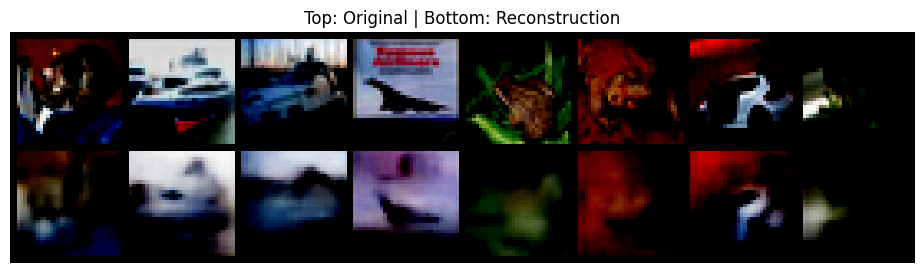

In [24]:
def show_reconstruction(n=8):
    vae.eval()
    imgs, _ = next(iter(test_loader))
    imgs = imgs[:n].to(device)
    with torch.no_grad():
        recon, _, _ = vae(imgs)

    imgs = imgs.cpu()
    recon = recon.cpu()
    comparison = torch.cat([imgs, recon])
    grid = make_grid(comparison, nrow=n)
    plt.figure(figsize=(15, 3))
    plt.imshow(np.transpose(grid.numpy(), (1, 2, 0)))
    plt.axis("off")
    plt.title("Top: Original | Bottom: Reconstruction")
    plt.show()

show_reconstruction()

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from scipy import linalg
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import DataLoader

# ------------------------
# INCEPTION v3 SETUP
# ------------------------
def get_inception_model():
    # 1. Load with original aux_logits configuration
    model = models.inception_v3(
        weights=models.Inception_V3_Weights.IMAGENET1K_V1,
        transform_input=False,
        aux_logits=True  # Must match pretrained weights config
    )
    
    # 2. Remove auxiliary heads while preserving original weights
    model.aux_logits = False
    model.AuxLogits = None  # Remove auxiliary classifier
    
    # 3. Replace final layer for feature extraction
    model.fc = nn.Identity()
    
    # 4. Freeze all parameters
    for param in model.parameters():
        param.requires_grad_(False)
        
    return model.eval().to(device)

inception_model = get_inception_model()

# ------------------------
# FID CALCULATION FUNCTIONS
# ------------------------
def calculate_fid(mu1, sigma1, mu2, sigma2, eps=1e-6):
    """Computes the Fréchet Inception Distance"""
    diff = mu1 - mu2
    covmean = linalg.sqrtm(sigma1.dot(sigma2), disp=False)[0]
    
    if not np.isfinite(covmean).all():
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))
    
    if np.iscomplexobj(covmean):
        covmean = covmean.real
        
    return diff.dot(diff) + np.trace(sigma1 + sigma2 - 2*covmean)

def preprocess_images(images):
    """Process images for Inception v3 input"""
    # 1. Resize to 299x299
    images = F.interpolate(images, size=299, mode='bilinear')
    
    # 2. Scale from [-1,1] (VAE-GAN output) to [0,1]
    images = (images + 1) * 0.5
    
    # 3. Apply ImageNet normalization
    images = transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )(images)
    
    return images

def get_features(loader, model, is_real=True):
    """Extract features from real or generated images"""
    features = []
    with torch.no_grad():
        for batch in loader:
            if is_real:
                images = batch[0].to(device)
            else:
                # Generate from random noise
                z = torch.randn(len(batch[0]), latent_dim).to(device)
                images = vae.decode(z)
            
            # Preprocess and extract features
            images = preprocess_images(images)
            pred = model(images)
            features.append(pred.cpu())
    
    return torch.cat(features).numpy()

# ------------------------
# MAIN FID CALCULATION
# ------------------------
def compute_fid():
    # Real images (test set)
    real_features = get_features(test_loader, inception_model, is_real=True)
    
    # Generated images (match test set size)
    n_samples = len(test_dataset)
    fake_dataset = torch.utils.data.TensorDataset(torch.randn(n_samples, 3, 32, 32))
    fake_loader = DataLoader(fake_dataset, batch_size=batch_size)
    fake_features = get_features(fake_loader, inception_model, is_real=False)
    
    # Calculate statistics
    mu_real, sigma_real = np.mean(real_features, axis=0), np.cov(real_features, rowvar=False)
    mu_fake, sigma_fake = np.mean(fake_features, axis=0), np.cov(fake_features, rowvar=False)
    
    return calculate_fid(mu_real, sigma_real, mu_fake, sigma_fake)

# Run calculation
fid_score = compute_fid()
print(f"FID Score: {fid_score:.2f}")

FID Score: 139.92


Files already downloaded and verified
Files already downloaded and verified
Epoch [1/200] | G Loss: 329602.5726 | D Loss: 0.0243
Epoch [2/200] | G Loss: 272844.8063 | D Loss: 0.0008
Epoch [3/200] | G Loss: 265732.2537 | D Loss: 0.0003
Epoch [4/200] | G Loss: 261836.2201 | D Loss: 0.0001
Epoch [5/200] | G Loss: 259582.6053 | D Loss: 0.0001
Epoch [6/200] | G Loss: 258101.2270 | D Loss: 0.0000
Epoch [7/200] | G Loss: 257143.8127 | D Loss: 0.0000
Epoch [8/200] | G Loss: 256265.7677 | D Loss: 0.0000
Epoch [9/200] | G Loss: 255759.5181 | D Loss: 0.0000
Epoch [10/200] | G Loss: 255278.9720 | D Loss: 0.0000
Epoch [11/200] | G Loss: 254838.5587 | D Loss: 0.0000
Epoch [12/200] | G Loss: 254506.7343 | D Loss: 0.0000
Epoch [13/200] | G Loss: 254136.6414 | D Loss: 0.0000
Epoch [14/200] | G Loss: 253883.7619 | D Loss: 0.0000
Epoch [15/200] | G Loss: 253691.5367 | D Loss: 0.0000
Epoch [16/200] | G Loss: 253410.8084 | D Loss: 0.0000
Epoch [17/200] | G Loss: 253179.2035 | D Loss: 0.0000
Epoch [18/200] 

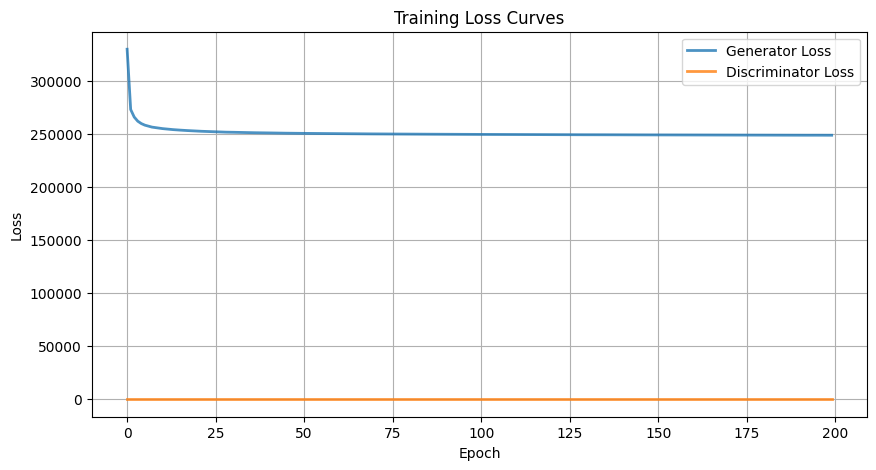

Model saved to vae_gan_cifar10.pth


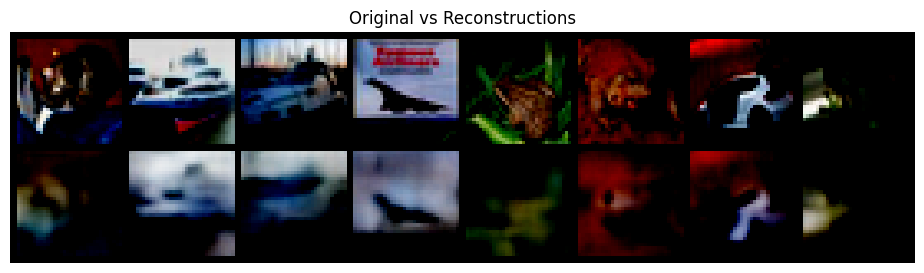

In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
from scipy import linalg
import torchvision.models as models
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

# ------------------------
# HYPERPARAMETERS (UPDATED)
# ------------------------
batch_size = 128
learning_rate = 2e-4
num_epochs = 200
latent_dim = 256
adv_weight = 0.1  # Weight for adversarial loss

# ------------------------
# MODELS
# ------------------------

class VAE_GAN(nn.Module):
    def __init__(self, latent_dim):
        super(VAE_GAN, self).__init__()
        
        # Enhanced Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
        )
        
        self.fc_mu = nn.Linear(256 * 4 * 4, latent_dim)
        self.fc_logvar = nn.Linear(256 * 4 * 4, latent_dim)
        
        # Enhanced Decoder/Generator
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256 * 4 * 4),
            nn.Unflatten(1, (256, 4, 4)),
            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, 4, 2, 1),
            nn.Tanh()
        )

    def decode(self, z):
        """Direct decoding from latent space"""
        return self.decoder(z)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        # Encoding
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        mu, logvar = self.fc_mu(x), self.fc_logvar(x)
        z = self.reparameterize(mu, logvar)
        
        # Decoding
        recon = self.decoder(z)
        return recon, mu, logvar

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 1, 4, 1, 0),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.model(x)
        return x.view(-1)

# ------------------------
# LOSSES & OPTIMIZERS
# ------------------------

def vae_loss(recon_x, x, mu, logvar):
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_loss

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vae = VAE_GAN(latent_dim).to(device)
discriminator = Discriminator().to(device)

optimizer_G = torch.optim.Adam(vae.parameters(), lr=learning_rate, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=learning_rate/2, betas=(0.5, 0.999))

# ------------------------
# TRAINING LOOP (UPDATED WITH LOSS TRACKING)
# ------------------------

def train_vae_gan(epochs):
    vae.train()
    discriminator.train()
    
    # Initialize loss tracking
    g_losses = []
    d_losses = []
    
    for epoch in range(epochs):
        total_loss_g = 0
        total_loss_d = 0
        
        for x, _ in train_loader:
            x = x.to(device)
            x = (x - 0.5) * 2.0  # Scale to [-1, 1]
            
            # Train Discriminator
            optimizer_D.zero_grad()
            
            real_pred = discriminator(x)
            loss_real = F.binary_cross_entropy(real_pred, torch.ones_like(real_pred))
            
            recon, mu, logvar = vae(x)
            fake_pred = discriminator(recon.detach())
            loss_fake = F.binary_cross_entropy(fake_pred, torch.zeros_like(fake_pred))
            
            d_loss = (loss_real + loss_fake) / 2
            d_loss.backward()
            optimizer_D.step()
            
            # Train Generator
            optimizer_G.zero_grad()
            
            loss_vae = vae_loss(recon, x, mu, logvar)
            fake_pred = discriminator(recon)
            g_loss = F.binary_cross_entropy(fake_pred, torch.ones_like(fake_pred))
            
            total_loss = loss_vae + adv_weight * g_loss
            total_loss.backward()
            optimizer_G.step()
            
            total_loss_g += total_loss.item()
            total_loss_d += d_loss.item()
        
        # Calculate average losses
        avg_g_loss = total_loss_g / len(train_loader)
        avg_d_loss = total_loss_d / len(train_loader)
        
        g_losses.append(avg_g_loss)
        d_losses.append(avg_d_loss)
        
        print(f"Epoch [{epoch+1}/{epochs}] | G Loss: {avg_g_loss:.4f} | D Loss: {avg_d_loss:.4f}")
    
    return g_losses, d_losses

# ------------------------
# DATA LOADING
# ------------------------

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# ------------------------
# TRAIN & VISUALIZE
# ------------------------

# Run training and get loss histories
g_losses, d_losses = train_vae_gan(num_epochs)

# Plot loss curves
plt.figure(figsize=(10, 5))
plt.plot(g_losses, label='Generator Loss', alpha=0.8, linewidth=2)
plt.plot(d_losses, label='Discriminator Loss', alpha=0.8, linewidth=2)
plt.title("Training Loss Curves")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# Save model
model_path = "vae_gan_cifar10.pth"
torch.save(vae.state_dict(), model_path)
print(f"Model saved to {model_path}")

# ------------------------
# VISUALIZATION FUNCTIONS
# ------------------------

def show_reconstruction(n=8):
    vae.eval()
    imgs, _ = next(iter(test_loader))
    imgs = imgs[:n].to(device)
    with torch.no_grad():
        recon, _, _ = vae(imgs)

    imgs = imgs.cpu()
    recon = recon.cpu()
    comparison = torch.cat([imgs, recon])
    grid = make_grid(comparison, nrow=n)
    plt.figure(figsize=(15, 3))
    plt.imshow(np.transpose(grid.numpy(), (1, 2, 0)))
    plt.axis("off")
    plt.title("Original vs Reconstructions")
    plt.show()

show_reconstruction()

# ------------------------
# FID CALCULATION (OPTIONAL)
# ------------------------

# [Keep your existing FID calculation code here]